## ДЗ №3 Двухуровневый пайплайн
#### В этой домашке вам предстоит написать с нуля двустадийную рекомендательную систему.

#### Дата выдачи: 10.03.25

#### Мягкий дедлайн: 31.03.25 23:59 MSK

#### Жесткий дедлайн: 7.04.25 23:59 MSK

### Описание
Это творческое задание, в котором вам необходимо реализовать полный цикл построения рекомендательной системы: реализовать кандидат генераторов, придумать и собрать признаки, обучить итоговый ранкер и заинференсить модели на всех пользователей.

Вам предоставляется два набора данных: `train.csv` и `test.csv`

In [20]:
# скачиваем данные
# если из этой ячейки не получается, то вот ссылка на папку https://drive.google.com/drive/folders/1HT0Apm8Jft0VPLJtdBBUGu9s1M7vZcoJ?usp=drive_link

# !pip3 install gdown


# import gdown
# # train
# url = "https://drive.google.com/file/d/1-CcS22-UpTJeNcFlA0dVLrEQn8jnI0d-/view?usp=drive_link"
# output = 'train.csv'
# gdown.download(url, output, quiet=False)

# # test
# url = "https://drive.google.com/file/d/11iz3xDh0IIoEIBY0dyRSvByY3qfiT3BG/view?usp=drive_link"
# output = 'test.csv'
# gdown.download(url, output, quiet=False)

In [1]:
!pip install optuna shap -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 4.0 MB/s eta 0:00:00


In [86]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
import xgboost as xgb
import shap

from typing import Union
from scipy.sparse.linalg import svds
from scipy.sparse import coo_matrix, coo_array, csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
from tqdm import tqdm


RANDOM_STATE = 42

np.random.seed(RANDOM_STATE)



### 1 Этап. Модели первого уровня. (max 3 балла)
В этом этапе вам необходимо разделить `train` датасет на 2 части: для обучения моделей первого уровня и для их валидации. Единственное условие для разбиения – разбивать нужно по времени. Данные для обучение будем называть `train_stage_1`, данные для валидации `valid_stage_1`. Объемы этих датасетов вы определяет самостоятельно.

Для начала нам нужно отобрать кандидатов при помощи легких моделей. Необходимо реализовать 3 типа моделей:
1. Любая эвристическая(алгоритмичная) модель на ваш выбор **(0.5 балл)**
2. Любая матричная факторизация на ваш выбор **(1 балл)**
3. Любая нейросетевая модель на ваш выбор **(1 балла)**

Не забудьте использовать скор каждой модели, как признак!



Каждая модель должна уметь:
1) для пары user_item предсказывать скор релевантности (масштаб скора не важен), важно обработать случаи, когда модель не можеn проскорить пользователя или айтем, вместо этого вернуть какое-то дефолтное значение
2) для всех пользователей вернуть top-k самых релевантных айтемов (тут вам скоры не нужны)


Дополнительно можно провести анализ кандидат генератов, измерить насколько различные айтемы они рекомендуют, например с помощью таких метрик как: [Ranked based overlap](https://github.com/changyaochen/rbo) или различные вариации [Diversity](https://github.com/MaurizioFD/RecSys2019_DeepLearning_Evaluation/blob/master/Base/Evaluation/metrics.py#L289). **(1 балл)**

In [87]:
def get_train_test_val(sample_size: int = 4000):
    df = pd.read_csv('train_part.csv')
    df_valid = pd.read_csv('test_part.csv')

    train_end = '2021-07-01'
    df_train = df[df['last_watch_dt'] < train_end].copy()
    df_test = df[df['last_watch_dt'] >= train_end].copy()

    train_users = df_train['user_id'].unique()
    train_items = df_train['item_id'].unique()

    df_test = df_test[df_test['user_id'].isin(train_users)]
    df_test = df_test[df_test['item_id'].isin(train_items)]

    unique_user_ids = df_train['user_id'].unique()

    selected_user_ids = np.random.choice(unique_user_ids, size=sample_size, replace=False)
    df_train_sample = df_train[df_train['user_id'].isin(selected_user_ids)].copy()
    df_test_sample = df_test[df_test['user_id'].isin(selected_user_ids)].copy()
    df_valid_sample = df_valid[df_valid['user_id'].isin(selected_user_ids)].copy()

    all_user_ids = np.unique(np.concatenate([df_train_sample['user_id'], df_test_sample['user_id'], df_valid_sample['user_id']]))
    all_item_ids = np.unique(np.concatenate([df_train_sample['item_id'], df_test_sample['item_id'], df_valid_sample['item_id']]))

    user_le = LabelEncoder()
    item_le = LabelEncoder()

    user_le.fit(all_user_ids)
    item_le.fit(all_item_ids)

    df_train_sample['user_id'] = user_le.transform(df_train_sample['user_id'])
    df_train_sample['item_id'] = item_le.transform(df_train_sample['item_id'])

    df_test_sample['user_id'] = user_le.transform(df_test_sample['user_id'])
    df_test_sample['item_id'] = item_le.transform(df_test_sample['item_id'])

    df_valid_sample['user_id'] = user_le.transform(df_valid_sample['user_id'])
    df_valid_sample['item_id'] = item_le.transform(df_valid_sample['item_id'])

    return df_train_sample, df_test_sample, df_valid_sample

In [52]:
df_train, df_test, df_valid = get_train_test_val()
df_train.shape, df_test.shape, df_valid.shape

((19161, 6), (6264, 6), (1407, 6))

1.1. Эвристическая модель (TopPopular)

In [4]:
class TopPopular:
    def __init__(self):
        self.item_popularity = None
        self.user_item_interactions = None

    def fit(self, df):

        self.user_item_interactions = df

        self.item_popularity = df.groupby('item_id').size().reset_index(name='popularity')

    def get_top_k_items(self, k: int = 100):
        return self.item_popularity.nlargest(k, 'popularity')['item_id'].tolist()

    def predict_relevance(self, user_id, item_id, default_value=0):
        return self.item_popularity.set_index('item_id').get(item_id, default_value)

In [26]:
toppop = TopPopular()
toppop.fit(df_train)

user_id = 2531
item_id = 2529
relevance_score = toppop.predict_relevance(user_id, item_id)
print(f'Relevance score for user {user_id} and item {item_id}: {relevance_score}')

top_k_items = toppop.get_top_k_items(5)
print(f'Top 5 popular items: {top_k_items}')

Relevance score for user 2531 and item 2529: 0
Top 5 popular items: [2564, 3785, 1008, 3404, 2393]


In [27]:
"""
добавим в df_train, df_test, df_valid для каждой пары скоры релевантности,
которые будут нужны в задании №3
"""
def get_toppop_popular_score(row):
    return toppop.predict_relevance(row['user_id'], row['item_id'])


df_train['top_popular_score'] = df_train.apply(get_toppop_popular_score, axis=1)
df_test['top_popular_score'] = df_test.apply(get_toppop_popular_score, axis=1)
df_valid['top_popular_score'] = df_valid.apply(get_toppop_popular_score, axis=1)

1.2. Модель матричной факторизации (SVD)

In [5]:
class SVD_factorization():
    def __init__(self, n_singular_values: int = -1) -> None:

        self.n_singular_values = n_singular_values
        self.recs = None
        self.user_features = None
        self.item_features = None
        self.user_id_to_index = {}
        self.item_id_to_index = {}

    def _df_to_matrix(self, df: pd.DataFrame) -> np.ndarray:

        interaction_matrix = df.pivot_table(index='user_id', columns='item_id', values='target', fill_value=0)
        self.user_id_to_index = {user_id: index for index, user_id in enumerate(interaction_matrix.index)}
        self.item_id_to_index = {item_id: index for index, item_id in enumerate(interaction_matrix.columns)}
        result = interaction_matrix.values
        return result

    def _make_svd(self, interactions: np.ndarray):

        U, S, Vt = np.linalg.svd(interactions, full_matrices=False)

        if self.n_singular_values != -1:
            U = U[:, :self.n_singular_values]
            S = S[:self.n_singular_values]
            Vt = Vt[:self.n_singular_values, :]

        self.user_features = U
        self.item_features = Vt.T
        return U, S, Vt

    def fit(self, df_train: pd.DataFrame):

        interactions = self._df_to_matrix(df_train)
        U, S, Vt = self._make_svd(interactions)

        self._calculate_recommendations(interactions)

    def _calculate_recommendations(self, interactions):

        n_users, n_items = interactions.shape
        relevance_scores = np.zeros((n_users, n_items))

        for user in range(n_users):
            interacted_items = np.where(interactions[user] > 0)[0]

            user_features = self.user_features[user]
            item_features = self.item_features

            relevance_scores[user] = np.dot(user_features, item_features.T)

            if np.isnan(relevance_scores[user]).any():
                relevance_scores[user] = np.nan_to_num(relevance_scores[user], nan=0.0)

            relevance_scores[user, interacted_items] = -np.inf

        self.recs = relevance_scores

    def predict_relevance(self, user_id: int, item_id: int) -> float:
        if self.user_features is None or self.item_features is None:
            raise ValueError("Model is not fitted yet.")

        user_index = self.user_id_to_index.get(user_id)
        if user_index is None:
            return 0

        item_index = self.item_id_to_index.get(item_id)
        if item_index is None:
            return 0

        user_features = self.user_features[user_index]
        item_features = self.item_features[item_index]

        relevance_score = np.dot(user_features, item_features)

        if np.isnan(relevance_score):
            return 0.0

        return float(relevance_score)

    def get_top_k_recommendations(self, user_id: int, top_k: int) -> list:

        user_index = self.user_id_to_index.get(user_id)
        if user_index is None:
            raise ValueError(f"User ID {user_id} not found in the model.")

        relevance_scores = self.recs[user_index]
        top_k_indices = np.argsort(relevance_scores)[-top_k:][::-1]

        return top_k_indices.tolist()

In [29]:
mf = SVD_factorization()

mf.fit(df_train)

In [30]:
mf.get_top_k_recommendations(user_id=2531, top_k=10)

[2529, 2890, 3188, 2746, 3132, 2580, 2680, 3118, 2707, 2909]

In [31]:
mf.predict_relevance(2531, 2529)

-5.6898815856032826e-18

In [32]:
"""
добавим в df_train, df_test, df_valid для каждой пары скоры релевантности,
которые будут нужны в задании №3
"""


def get_svd_popular_score(row):
    return mf.predict_relevance(row['user_id'], row['item_id'])

df_train['svd_popular_score'] = df_train.apply(get_svd_popular_score, axis=1)
df_test['svd_popular_score'] = df_test.apply(get_svd_popular_score, axis=1)
df_valid['svd_popular_score'] = df_valid.apply(get_svd_popular_score, axis=1)

1.3. Модель NCF (колаборативная фильтрация на основе нейровнной сети)

In [70]:
class NCFModel:
    def __init__(self, train_data, test_data, valid_data, embedding_dim=8, device='cpu'):
        self.device = device
        self.train_data = train_data
        self.test_data = test_data
        self.valid_data = valid_data
        self.embedding_dim = embedding_dim

        self.prepare_data()

        self.model = self.NCFRecommender(self.num_users, self.num_items, self.embedding_dim).to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    class NCFRecommender(nn.Module):
        def __init__(self, num_users, num_items, embedding_dim):
            super(NCFModel.NCFRecommender, self).__init__()
            self.user_embedding = nn.Embedding(num_users, embedding_dim)
            self.item_embedding = nn.Embedding(num_items, embedding_dim)
            self.fc = nn.Sequential(
                nn.Linear(embedding_dim * 2, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            )

        def forward(self, user_index, item_index):
            user_vec = self.user_embedding(user_index)
            item_vec = self.item_embedding(item_index)
            concat = torch.cat([user_vec, item_vec], dim=-1)
            return self.fc(concat)

    def prepare_data(self):
        """
        Этот код нужен для корректного определения диапазонов
        user_id, item_id при формировании эмбеддингов
        обучение все равно происходит только на тренировочной выборке
        """
        all_data = pd.concat([self.train_data[['user_id', 'item_id', 'target']],
                              self.test_data[['user_id', 'item_id']],
                              self.valid_data[['user_id', 'item_id']]],
                             ignore_index=True)

        user_ids = all_data['user_id'].unique()
        item_ids = all_data['item_id'].unique()

        self.user_id_mapping = {id: idx for idx, id in enumerate(user_ids)}
        self.item_id_mapping = {id: idx for idx, id in enumerate(item_ids)}

        self.train_data['user_index'] = self.train_data['user_id'].map(self.user_id_mapping)
        self.train_data['item_index'] = self.train_data['item_id'].map(self.item_id_mapping)

        self.test_data['user_index'] = self.test_data['user_id'].map(self.user_id_mapping)
        self.test_data['item_index'] = self.test_data['item_id'].map(self.item_id_mapping)
        self.valid_data['user_index'] = self.valid_data['user_id'].map(self.user_id_mapping)
        self.valid_data['item_index'] = self.valid_data['item_id'].map(self.item_id_mapping)

        X = self.train_data[['user_index', 'item_index']]
        y = self.train_data['target']

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        self.X_train_tensor = torch.tensor(self.X_train.values, dtype=torch.long).to(self.device)
        self.y_train_tensor = torch.tensor(self.y_train.values, dtype=torch.float32).to(self.device)

        self.num_users = len(user_ids)
        self.num_items = len(item_ids)

    def fit(self, epochs=10, batch_size=32):
        self.model.train()
        dataset = torch.utils.data.TensorDataset(self.X_train_tensor[:, 0], self.X_train_tensor[:, 1], self.y_train_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for user_index, item_index, target in dataloader:
                self.optimizer.zero_grad()
                output = self.model(user_index, item_index)
                loss = self.criterion(output.squeeze(), target)
                loss.backward()
                self.optimizer.step()
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

    def predict_relevance(self, user_id, item_id):
        user_index = self.user_id_mapping.get(user_id)
        item_index = self.item_id_mapping.get(item_id)
        self.model.eval()
        with torch.no_grad():
            user_index_tensor = torch.tensor(user_index, dtype=torch.long).to(self.device)
            item_index_tensor = torch.tensor(item_index, dtype=torch.long).to(self.device)
            predictions = self.model(user_index_tensor, item_index_tensor).cpu().numpy()
            return float(predictions[0])

    def get_top_k_recommendations(self, user_id, k=5):
        user_index = self.user_id_mapping.get(user_id)
        item_indices = list(self.item_id_mapping.values())

        scores = []
        for item_index in item_indices:
            score = self.predict_relevance(user_index, item_index)
            scores.append(score)

        scores = np.array(scores)
        top_k_indices = np.argsort(scores)[-k:][::-1]

        top_k_recommendations = [int(list(self.item_id_mapping.keys())[i]) for i in top_k_indices]

        return top_k_recommendations

In [71]:
ncf = NCFModel(df_train, df_test, df_valid, embedding_dim=8)
ncf.fit(epochs=10, batch_size=2)

Epoch 1/10, Loss: 0.6391
Epoch 2/10, Loss: 0.4863
Epoch 3/10, Loss: 1.0274
Epoch 4/10, Loss: 0.4089
Epoch 5/10, Loss: 0.4427
Epoch 6/10, Loss: 0.9849
Epoch 7/10, Loss: 0.1749
Epoch 8/10, Loss: 0.5398
Epoch 9/10, Loss: 0.3578
Epoch 10/10, Loss: 0.4425


In [73]:
user_id = 2531
item_id = 2529

predicted_score = ncf.predict_relevance(user_id, item_id)
print(f'relevance score for user {user_id} and item {item_id}: {predicted_score}')

top_k_recommendations = ncf.get_top_k_recommendations(user_id)
print(f'top K recommendations for user {user_id}: {top_k_recommendations}')

relevance score for user 2531 and item 2529: 0.0035994022618979216
top K recommendations for user 2531: [3262, 2183, 1896, 2996, 1385]


In [47]:
"""
добавим в df_train, df_test, df_valid для каждой пары скоры релевантности,
которые будут нужны в задании №3
"""


def get_ncf_score(row):
    return ncf.predict_relevance(row['user_id'], row['item_id'])


df_train['ncf_popular_score'] = df_train.apply(get_ncf_score, axis=1)
df_test['ncf_popular_score'] = df_test.apply(get_ncf_score, axis=1)
df_valid['ncf_popular_score'] = df_valid.apply(get_ncf_score, axis=1)


### 2 Этап. Генерация и сборка признаков. (max 2 балла)
Необходимо собрать минимум 10 осмысленных (`np.radndom.rand()` не подойдет) признаков, при этом:
1. 2 должны относиться только к сущности "пользователь" (например средний % просмотра фильмов у этой возрастной категории)
2. 2 должны относиться только к сущности "айтем" (например средний средний % просмотра данного фильма)
3. 6 признаков, которые показывают связь пользователя и айтема (например средний % просмотра фильмов с данным актером (айтем) у пользователей с таким же полом (пользователь)).

### ВАЖНО!  

1. **В датасете есть колонка `watched_prct`. Ее можно использовать для генерации признаков (например сколько пользователь в среднем смотрит фильмы), но нельзя подавать в модель, как отдельную фичу, потому что она напрямую связана с target.**
2. **Все признаки должны быть собраны без дата лика, то есть если пользователь посмотрел фильм 10 августа, то признаки мы можем считать только на данных до 9 августа включительно.**


### Разбалловка
Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`. Поэтому есть 2 варианта сборки признаков, **реализовать нужно только 1 из них:**
1. Для обучения собираем признаки на первый день `valid_stage_1`, а для теста на первый день `test`. Например, если `valid_stage_1` начинается 5 сентября, то все признаки мы можем собирать только по 4 сентября включительно. **(1 балл)**
2. Признаки будем собирать честно на каждый день, то есть на 5 сентября собираем с начала до 4, на 6 сентября с начала до 5 и т.д. **(2 балла)**

In [48]:
item_features = pd.read_csv('items.csv')
user_features = pd.read_csv('users.csv')

In [49]:
user_features.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0


In [50]:
item_features.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж..."


Видно, что некоторые колонки являются составным (например жанры, и актеры). Попробуем выделить из них два первых жанра и актера

In [51]:
genres_split = item_features['genres'].str.split(', ', expand=True)
item_features['first_genre'] = genres_split[0]

actors_split = item_features['actors'].str.split(', ', expand=True)
item_features['first_actor'] = actors_split[0]

directors_split = item_features['directors'].str.split(', ', expand=True)
item_features['first_director'] = actors_split[0]

In [52]:
item_features.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords,first_genre,first_actor,first_director
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ...",драмы,Адольфо Фернандес,Адольфо Фернандес
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео...",зарубежные,Адам Палли,Адам Палли
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,NaN,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг...",криминал,Адриан Холмс,Адриан Холмс
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,NaN,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю...",драмы,Александра Риддлстон-Барретт,Александра Риддлстон-Барретт
4,16268,film,Все решает мгновение,NaN,1978.0,"драмы, спорт, советские, мелодрамы",СССР,NaN,12.0,Ленфильм,Виктор Садовский,"Александр Абдулов, Александр Демьяненко, Алекс...",Расчетливая чаровница из советского кинохита «...,"Все, решает, мгновение, 1978, СССР, сильные, ж...",драмы,Александр Абдулов,Александр Абдулов


В качестве фичей предлагаю взять:
1. Для сущности user:
- медианный процент просмотра фильмов по полу
- медианный процент просмотра фильмов по доходу (возможно доход связан с тем как часто люди смотрят фильмы)
2. Для сущености item - предлагаю взять:
- медианный процент просмотра того или иного фильма всеми юзерами
- медианный процент просмотра фильмов по жанру.
3. В качестве составных фичей предлагаю взять:
- медианный процент просмотра фильмов данного режиссера у пользователей с таким же полом
- медианный процент просмотра фильмов в жанре у пользователя с таким же полом
- медианный процент просмотра фильмов с данным актером у пользователей с таким же полом
- медианный процент просмотра фильмов с данным жанром у пользователей с таким же возрастом
- медианный процент просмотра фильмов с данным актером у пользователей с таким же возрастом
- медианный процент просмотра фильмов данного жанра у пользователей с таким же доходом

Напишем функцию для создания фичей

In [303]:
def calculate_features(df, items, users):

    item_interactions_df = df.merge(items, on='item_id', how='left')
    item_users_df = item_interactions_df.merge(users, on='user_id', how='left')


    # медианный процент просмотра фильмов по полу
    item_users_df['med_watched_pct_by_sex'] = item_users_df.groupby('sex')['watched_pct'].transform('median')


    # медианный процент просмотра фильмов по доходу
    item_users_df['med_watched_pct_by_income'] = item_users_df.groupby('income')['watched_pct'].transform('median')

    # медианный процент просмотра того или иного фильма всеми юзерами
    item_users_df['median_watched_pct_all'] = item_users_df.groupby('item_id')['watched_pct'].transform('median')


    # медианный процент просмотра фильмов по жанру
    item_users_df['median_watched_by_genre'] = item_users_df.groupby('first_genre')['watched_pct'].transform('median')


    # медианный процент просмотра фильмов данного режиссера у пользователей с таким же полом
    item_users_df['median_watched_pct_by_director_sex'] = item_users_df.groupby(['first_director', 'sex'])['watched_pct'].transform('median')


    # медианный процент просмотра фильмов в жанре у пользователя с таким же полом
    item_users_df['median_watched_pct_by_genre_gender'] = item_users_df.groupby(['first_genre', 'sex'])['watched_pct'].transform('median')


    # медианный процент просмотра фильмов с данным актером у пользователей с таким же полом
    item_users_df['median_watched_pct_by_actor_gender'] = item_users_df.groupby(['first_actor', 'sex'])['watched_pct'].transform('median')


    # медианный процент просмотра фильмов с данным жанром у пользователей с таким же возрастом
    item_users_df['median_watched_pct_by_genre_age'] = item_users_df.groupby(['first_genre', 'age'])['watched_pct'].transform('median')


    # медианный процент просмотра фильмов с данным актером у пользователей с таким же возрастом
    item_users_df['median_watched_pct_by_actor_age'] = item_users_df.groupby(['first_actor', 'age'])['watched_pct'].transform('median')

    # медианный процент просмотра фильмов данного жанра у пользователей с таким же доходом
    item_users_df['median_watched_pct_by_genre_income'] = item_users_df.groupby(['first_genre', 'income'])['watched_pct'].transform('median')


    features_df = item_users_df[
        ['target',
         'med_watched_pct_by_sex',
         'med_watched_pct_by_income',
         'median_watched_pct_all',
         'median_watched_by_genre',
         'median_watched_pct_by_director_sex',
         'median_watched_pct_by_genre_gender',
         'median_watched_pct_by_actor_gender',
         'median_watched_pct_by_genre_age',
         'median_watched_pct_by_actor_age',
         'median_watched_pct_by_genre_income',
         'top_popular_score',
         'svd_popular_score',
         'ncf_popular_score']
    ]

    return features_df

In [54]:
df_train_feat = calculate_features(df_train, item_features, user_features)
df_test_feat = calculate_features(df_test, item_features, user_features)
df_val_feat = calculate_features(df_valid, item_features, user_features)


### 3 Этап. Обучение финального ранкера (max 2 балла)
Собрав все признаки из этапа 2, добавив скоры моделей из этапа 1 для каждой пары пользователь-айтем (где это возможно), пришло время обучать ранкер. В качестве ранкера можно использовать либо [xgboost](https://xgboost.readthedocs.io/en/stable/) или [catboost](https://catboost.ai/). Обучать можно как `Classfier`, так и `Ranker`, выбираем то, что лучше сработает. Обучение ранкера будет проходить на `valid_stage_1`, как  раз на которой мы валидировали модели, а тестировать на `test`, которую мы до сих пор не трогали.  Заметьте, что у нас в тесте есть холодные пользователи – те, кого не было в train и активные – те, кто был в train. Возможно их стоит обработать по отдельности (а может и нет).  
(1 балл)

После получения лучшей модели надо посмотреть на важность признаков и [shap values](https://shap.readthedocs.io/en/latest/index.html), чтобы:
1. Интерпритировать признаки, которые вы собрали, насколько они полезные
2. Проверить наличие ликов – если важность фичи в 100 раз больше, чем у всех остальных, то явно что-то не то  

(1 балл)






In [55]:
X_train = df_test_feat.drop(columns=['target'])
y_train = df_test_feat['target']

X_test = df_val_feat.drop(columns=['target'])
y_test = df_val_feat['target']

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-2, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 10),
        'random_state': 42
    }

    model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'],
                      evals=[(dtest, 'test')], early_stopping_rounds=50, verbose_eval=False)

    preds = model.predict(dtest)
    auc = roc_auc_score(y_test, preds)

    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)
print("Best AUC: ", study.best_value)

[I 2025-03-29 07:17:51,125] A new study created in memory with name: no-name-5b307fcd-1185-42c0-9afe-551d0fa997b5
<ipython-input-55-770d96ed30a0>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
<ipython-input-55-770d96ed30a0>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-2, 10),
<ipython-input-55-770d96ed30a0>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_logunif

Best hyperparameters:  {'learning_rate': 0.019334592186676464, 'max_depth': 6, 'n_estimators': 615, 'subsample': 0.9150806888892337, 'colsample_bytree': 0.5784575050143604, 'lambda': 0.01808717848599597, 'alpha': 7.010379206396991}
Best AUC:  0.9513541871598137


In [56]:
best_params = study.best_params
best_model = xgb.train(best_params, dtrain, num_boost_round=best_params['n_estimators'])

preds = best_model.predict(dtest)
test_auc = roc_auc_score(y_test, preds)
print("Test ROC-AUC: ", test_auc)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [07:18:56] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


Test ROC-AUC:  0.9508273766585787


<ipython-input-57-14ff93a334c2>:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


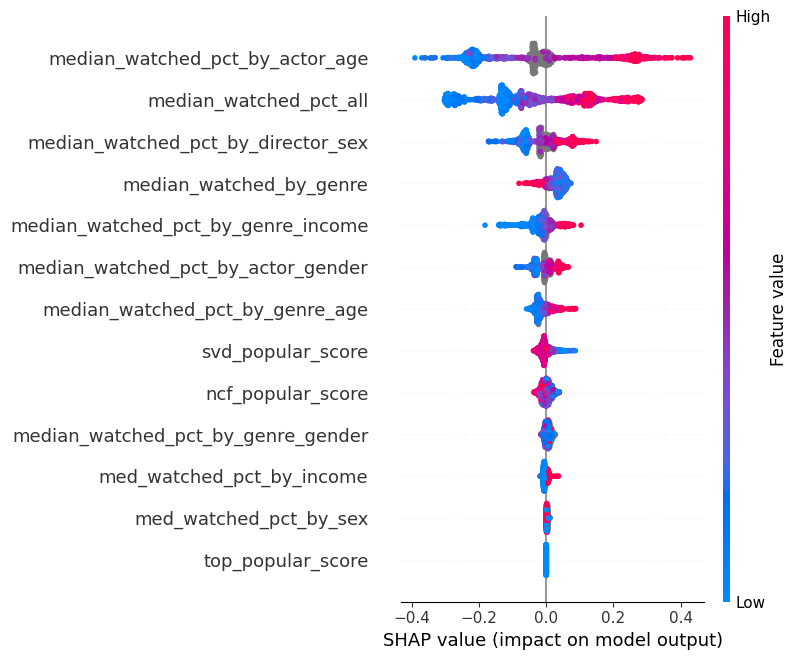

In [57]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

Согласно SHAP:
1. Наиболее значимым признаком является медианный процент просмотра фильма с конкретным актером у пользователей с таким же возрастом. Чем ниже значение, тем ниже вероятность просмотра, чем выше медианный процент - тем выше вероятность просмотра. В целом данный показатель и его влияние на таргет вполне логичны:
- разные поколения были активными зрителями кино в разные периоды времени (когда наши бабушки и родители активными зрителями кино, были популярны одни актеры, сейчас другие)
- разные поколения предпочитают фильмы из разных периодов времени, для каждого периода характерны свои популярные актеры
2. Вторым по значимости - медианный процент просмотра. В целом вполне логично. Если фильм популярен он будет иметь высокий медианный процент просмотра у всех пользователей. Почему бы и не рекомендовать такой фильм к просмотру.
3. Медианный процент просмотра фильмов данного режиссера у пользователей с таким же полом. Логично предположение, что "в среднем" есть разница между режиссерами, которые нравятся женщинам и мужчинам. Это может быть связано с жанрами, в которых работают данные режиссеры, с любимыми актерами данного режиссера (например Педро Альмадовар во многие свои фильмы приглашал сниматься Пенелопу Крус)
4. Медианный процент просмотра фильмов по жанру. Данный показатель получился весьма интересным: чем ниже его значение, тем выше вероятность просмотра. Это может быть связано как с эффектом нишевых жанров (малопопулярны в целом, но имеют преданную аудиторию). Можно было бы поисследовать данный фактор в сочетании с другими (например, повторными просмотрами фильма и тп)
5. Медианный процент просмотра фильмов данного жанра у пользователей с таким же доходом также оказался важным. По всей видимости пользователи с разным уровнем дохода предпочитают смотреть разные жанры фильмов.
6. Медианный процент просмотра фильмов в жанре у пользователя с таким же полом. Видимо это также связано с разными гендерными предпочтениями по режиссерам, фильмам, жанрам и актерам.

Остальные фичи не столь значимы. Также невысокое влияние имеют разные модели факторизации: SVD, NCF.

В целом можно сказать, что лики отсутствует. Диаграма не выявила признаков, имеющих непропорционально высокое влияние в сравнении с остальными (100 раз и более)


### 4 Этап. Инференс лучшего ранкера (max 3 балла)

Теперь мы хотим построить рекомендации "на завтра", для этого нам нужно:

1. Обучить модели первого уровня на всех (train+test) данных (0.5 балла)
2. Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)
3. "Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)
4. Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)
5. Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)
6. Посчитать разнообразие(Diversity) и построить график от Diversity(k) (0.5 балла)


Все гиперпараметры (N, k) определяете только Вы!

Обучить модели первого уровня на всех (train+test) данных (0.5 балла)

In [342]:
df_train, df_test, df_valid = get_train_test_val(sample_size=200)
df_train_full = pd.concat([df_train, df_test], ignore_index=True)

In [343]:
%%time

toppop_full = TopPopular()
toppop_full.fit(df_train_full)

CPU times: user 2.18 ms, sys: 2 µs, total: 2.18 ms
Wall time: 2.14 ms


In [344]:
%%time

mf_full = SVD_factorization()
mf_full.fit(df_train_full)

CPU times: user 1.61 s, sys: 4.01 ms, total: 1.62 s
Wall time: 1.71 s


In [345]:
class NCFModelFull:
    def __init__(self, train_data, test_data, embedding_dim=8, device='cpu'):
        self.device = device
        self.train_data = train_data
        self.test_data = test_data
        self.embedding_dim = embedding_dim

        self.prepare_data()

        self.model = self.NCFRecommender(self.num_users, self.num_items, self.embedding_dim).to(self.device)
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

    class NCFRecommender(nn.Module):
        def __init__(self, num_users, num_items, embedding_dim):
            super().__init__()
            self.user_embedding = nn.Embedding(num_users, embedding_dim)
            self.item_embedding = nn.Embedding(num_items, embedding_dim)
            self.fc = nn.Sequential(
                nn.Linear(embedding_dim * 2, 64),
                nn.ReLU(),
                nn.Linear(64, 32),
                nn.ReLU(),
                nn.Linear(32, 1),
                nn.Sigmoid()
            )

        def forward(self, user_index, item_index):
            user_vec = self.user_embedding(user_index)
            item_vec = self.item_embedding(item_index)
            concat = torch.cat([user_vec, item_vec], dim=-1)
            return self.fc(concat)

    def prepare_data(self):
        all_data = pd.concat([self.train_data[['user_id', 'item_id', 'target']],
                              self.test_data[['user_id', 'item_id']]],
                             ignore_index=True)

        user_ids = all_data['user_id'].unique()
        item_ids = all_data['item_id'].unique()

        self.user_id_mapping = {id: idx for idx, id in enumerate(user_ids)}
        self.item_id_mapping = {id: idx for idx, id in enumerate(item_ids)}

        self.train_data['user_index'] = self.train_data['user_id'].map(self.user_id_mapping)
        self.train_data['item_index'] = self.train_data['item_id'].map(self.item_id_mapping)

        self.test_data['user_index'] = self.test_data['user_id'].map(self.user_id_mapping)
        self.test_data['item_index'] = self.test_data['item_id'].map(self.item_id_mapping)

        X = self.train_data[['user_index', 'item_index']]
        y = self.train_data['target']

        self.X_train_tensor = torch.tensor(X.values, dtype=torch.long).to(self.device)
        self.y_train_tensor = torch.tensor(y.values, dtype=torch.float32).to(self.device)

        self.num_users = len(user_ids)
        self.num_items = len(item_ids)


    def fit(self, epochs=10, batch_size=32):
        self.model.train()
        dataset = torch.utils.data.TensorDataset(self.X_train_tensor[:, 0], self.X_train_tensor[:, 1], self.y_train_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(epochs):
            for user_index, item_index, target in dataloader:
                self.optimizer.zero_grad()
                output = self.model(user_index, item_index)
                loss = self.criterion(output.view(-1), target)
                loss.backward()
                self.optimizer.step()
            print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')

    def predict_relevance(self, user_id, item_id):
        user_index = self.user_id_mapping.get(user_id)
        item_index = self.item_id_mapping.get(item_id)
        self.model.eval()
        with torch.no_grad():
            user_index_tensor = torch.tensor(user_index, dtype=torch.long).to(self.device)
            item_index_tensor = torch.tensor(item_index, dtype=torch.long).to(self.device)
            predictions = self.model(user_index_tensor, item_index_tensor).cpu().numpy()
            return float(predictions[0])

    def get_top_k_recommendations(self, user_id, k=5):
        user_index = self.user_id_mapping.get(user_id)
        item_indices = np.array(list(self.item_id_mapping.values()))

        scores = np.array([
            self.predict_relevance(user_index, item_index)
            for item_index in item_indices
        ])

        top_k_indices = np.argsort(scores)[-k:][::-1]

        item_ids = list(self.item_id_mapping.keys())
        return [int(item_ids[i]) for i in top_k_indices]

In [346]:
%%time

ncf_full = NCFModelFull(df_train_full, df_valid)
ncf_full.fit(epochs=10, batch_size=2)

Epoch 1/10, Loss: 0.6601
Epoch 2/10, Loss: 0.4670
Epoch 3/10, Loss: 0.7889
Epoch 4/10, Loss: 0.3807
Epoch 5/10, Loss: 0.0935
Epoch 6/10, Loss: 0.6468
Epoch 7/10, Loss: 0.2026
Epoch 8/10, Loss: 0.1377
Epoch 9/10, Loss: 0.7894
Epoch 10/10, Loss: 0.0740
CPU times: user 13.4 s, sys: 22.9 ms, total: 13.4 s
Wall time: 15.5 s


Для каждой модели первого уровня для каждого пользователя сгененировать N кандидатов (0.5 балла)

In [347]:
def get_recs_toppop(user_id):
    return toppop_full.get_top_k_items(k=5)

def get_recs_svd(user_id):
    return mf_full.get_top_k_recommendations(user_id, top_k=5)

def get_recs_ncf(user_id):
    return ncf_full.get_top_k_recommendations(user_id, k=5)

df_users_recs_train = df_train_full[['user_id']].drop_duplicates().reset_index(drop=True)

df_users_recs_train['top_popular_recs'] = df_users_recs_train['user_id'].apply(get_recs_toppop)
df_users_recs_train['svd_recs'] = df_users_recs_train['user_id'].apply(get_recs_svd)
df_users_recs_train['ncf_recs'] = df_users_recs_train['user_id'].apply(get_recs_ncf)

In [348]:
df_users_recs_train.head()

,user_id,top_popular_recs,svd_recs,ncf_recs
0,45,"[524, 773, 205, 486, 697]","[341, 524, 24, 625, 358]","[824, 394, 766, 717, 562]"
1,186,"[524, 773, 205, 486, 697]","[687, 462, 354, 5, 272]","[638, 824, 394, 551, 562]"
2,46,"[524, 773, 205, 486, 697]","[30, 108, 99, 33, 65]","[394, 824, 766, 638, 472]"
3,77,"[524, 773, 205, 486, 697]","[10, 25, 78, 65, 54]","[717, 824, 766, 394, 726]"
4,73,"[524, 773, 205, 486, 697]","[586, 666, 704, 702, 246]","[824, 717, 766, 394, 726]"


In [349]:
df_users_recs_valid = df_valid[['user_id']].drop_duplicates().reset_index(drop=True)

df_users_recs_valid['top_popular_recs'] = df_users_recs_valid['user_id'].apply(get_recs_toppop)
df_users_recs_valid['svd_recs'] = df_users_recs_valid['user_id'].apply(get_recs_svd)
df_users_recs_valid['ncf_recs'] = df_users_recs_valid['user_id'].apply(get_recs_ncf)

In [350]:
df_users_recs_valid.head()

,user_id,top_popular_recs,svd_recs,ncf_recs
0,199,"[524, 773, 205, 486, 697]","[586, 397, 756, 426, 600]","[394, 766, 824, 521, 717]"
1,5,"[524, 773, 205, 486, 697]","[431, 13, 346, 5, 426]","[824, 394, 766, 638, 717]"
2,6,"[524, 773, 205, 486, 697]","[5, 481, 63, 649, 195]","[824, 766, 726, 394, 717]"
3,3,"[524, 773, 205, 486, 697]","[141, 46, 9, 12, 26]","[472, 394, 824, 766, 339]"
4,123,"[524, 773, 205, 486, 697]","[382, 625, 341, 397, 756]","[824, 717, 562, 555, 281]"


"Склеить" всех кандидатов для каждого пользователя (дубли выкинуть), посчитать скоры от всех моделей (0.5 балла)

In [351]:
df_users_recs_train['recs'] = df_users_recs_train.apply(lambda row: list(set(row['top_popular_recs'] + row['svd_recs'] + row['ncf_recs'])), axis=1)
df_users_recs_valid['recs'] = df_users_recs_valid.apply(lambda row: list(set(row['top_popular_recs'] + row['svd_recs'] + row['ncf_recs'])), axis=1)

df_users_recs_train = df_users_recs_train.drop(columns=['top_popular_recs', 'svd_recs', 'ncf_recs'])
df_users_recs_valid = df_users_recs_valid.drop(columns=['top_popular_recs', 'svd_recs', 'ncf_recs'])

In [352]:
df_users_recs_train.head()

,user_id,recs
0,45,"[773, 486, 358, 394, 524, 205, 717, 625, 824, ..."
1,186,"[354, 773, 486, 5, 551, 394, 524, 205, 462, 68..."
2,46,"[33, 65, 99, 773, 486, 472, 394, 638, 524, 205..."
3,77,"[65, 773, 486, 10, 394, 524, 205, 78, 717, 766..."
4,73,"[704, 773, 486, 586, 394, 524, 205, 717, 766, ..."


In [353]:
# сделаем из полученных кандидатов датафрейм с интеракциями и подтянем значения таргета
df_users_recs_train = df_users_recs_train.explode('recs')
df_users_recs_train = df_users_recs_train.rename(columns={'recs': 'item_id'})

df_users_recs_valid = df_users_recs_valid.explode('recs')
df_users_recs_valid = df_users_recs_valid.rename(columns={'recs': 'item_id'})

df_users_recs_train = df_users_recs_train.merge(df_train_full, on=['user_id', 'item_id'], how='inner')
df_users_recs_valid = df_users_recs_valid.merge(df_valid, on=['user_id', 'item_id'], how='inner')

In [354]:
df_users_recs_train.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,user_index,item_index
0,186,773,2021-07-30,326,0.0,0,1,466
1,186,205,2021-07-30,847,13.0,0,1,219
2,197,524,2021-05-16,1945,10.0,0,8,269
3,197,84,2021-03-22,14,0.0,0,8,41
4,21,486,2021-07-15,95,1.0,0,9,624


Собрать фичи для ваших кандидатов (теперь можем считать признаки на всех данных) (0.5 балла)

In [355]:
def calculate_features(df, items, users):

    item_interactions_df = df.merge(items, on='item_id', how='left')
    item_users_df = item_interactions_df.merge(users, on='user_id', how='left')


    # медианный процент просмотра фильмов по полу
    item_users_df['med_watched_pct_by_sex'] = item_users_df.groupby('sex')['watched_pct'].transform('median')


    # медианный процент просмотра фильмов по доходу
    item_users_df['med_watched_pct_by_income'] = item_users_df.groupby('income')['watched_pct'].transform('median')

    # медианный процент просмотра того или иного фильма всеми юзерами
    item_users_df['median_watched_pct_all'] = item_users_df.groupby('item_id')['watched_pct'].transform('median')


    # медианный процент просмотра фильмов по жанру
    item_users_df['median_watched_by_genre'] = item_users_df.groupby('first_genre')['watched_pct'].transform('median')


    # медианный процент просмотра фильмов данного режиссера у пользователей с таким же полом
    item_users_df['median_watched_pct_by_director_sex'] = item_users_df.groupby(['first_director', 'sex'])['watched_pct'].transform('median')


    # медианный процент просмотра фильмов в жанре у пользователя с таким же полом
    item_users_df['median_watched_pct_by_genre_gender'] = item_users_df.groupby(['first_genre', 'sex'])['watched_pct'].transform('median')


    # медианный процент просмотра фильмов с данным актером у пользователей с таким же полом
    item_users_df['median_watched_pct_by_actor_gender'] = item_users_df.groupby(['first_actor', 'sex'])['watched_pct'].transform('median')


    # медианный процент просмотра фильмов с данным жанром у пользователей с таким же возрастом
    item_users_df['median_watched_pct_by_genre_age'] = item_users_df.groupby(['first_genre', 'age'])['watched_pct'].transform('median')


    # медианный процент просмотра фильмов с данным актером у пользователей с таким же возрастом
    item_users_df['median_watched_pct_by_actor_age'] = item_users_df.groupby(['first_actor', 'age'])['watched_pct'].transform('median')

    # медианный процент просмотра фильмов данного жанра у пользователей с таким же доходом
    item_users_df['median_watched_pct_by_genre_income'] = item_users_df.groupby(['first_genre', 'income'])['watched_pct'].transform('median')


    features_df = item_users_df[
        ['user_id', # добавил
         'item_id', # добавил
         'target',
         'med_watched_pct_by_sex',
         'med_watched_pct_by_income',
         'median_watched_pct_all',
         'median_watched_by_genre',
         'median_watched_pct_by_director_sex',
         'median_watched_pct_by_genre_gender',
         'median_watched_pct_by_actor_gender',
         'median_watched_pct_by_genre_age',
         'median_watched_pct_by_actor_age',
         'median_watched_pct_by_genre_income',
         'top_popular_score',
         'svd_popular_score',
         'ncf_popular_score']
    ]

    return features_df

In [356]:
def get_ncf_score(row):
    return ncf_full.predict_relevance(row['user_id'], row['item_id'])

def get_svd_popular_score(row):
    return mf_full.predict_relevance(row['user_id'], row['item_id'])

def get_toppop_popular_score(row):
    return toppop_full.predict_relevance(row['user_id'], row['item_id'])


df_users_recs_train['top_popular_score'] = df_users_recs_train.apply(get_toppop_popular_score, axis=1)
df_users_recs_valid['top_popular_score'] = df_users_recs_valid.apply(get_toppop_popular_score, axis=1)

df_users_recs_train['ncf_popular_score'] = df_users_recs_train.apply(get_ncf_score, axis=1)
df_users_recs_valid['ncf_popular_score'] = df_users_recs_valid.apply(get_ncf_score, axis=1)

df_users_recs_train['svd_popular_score'] = df_users_recs_train.apply(get_svd_popular_score, axis=1)
df_users_recs_valid['svd_popular_score'] = df_users_recs_valid.apply(get_svd_popular_score, axis=1)

item_features = pd.read_csv('items.csv')
user_features = pd.read_csv('users.csv')

genres_split = item_features['genres'].str.split(', ', expand=True)
item_features['first_genre'] = genres_split[0]

actors_split = item_features['actors'].str.split(', ', expand=True)
item_features['first_actor'] = actors_split[0]

directors_split = item_features['directors'].str.split(', ', expand=True)
item_features['first_director'] = actors_split[0]

df_train_feat = calculate_features(df_users_recs_train, item_features, user_features)
df_val_feat = calculate_features(df_users_recs_valid, item_features, user_features)

In [357]:
df_train_feat.head()

,user_id,item_id,target,med_watched_pct_by_sex,med_watched_pct_by_income,median_watched_pct_all,median_watched_by_genre,median_watched_pct_by_director_sex,median_watched_pct_by_genre_gender,median_watched_pct_by_actor_gender,median_watched_pct_by_genre_age,median_watched_pct_by_actor_age,median_watched_pct_by_genre_income,top_popular_score,svd_popular_score,ncf_popular_score
0,186,773,0,27.5,38.0,75.0,81.5,63.0,69.0,63.0,75.5,50.5,75.0,0,-0.006915,0.381060
1,186,205,0,27.5,38.0,13.0,13.0,NaN,13.0,NaN,38.0,NaN,13.0,0,-0.014048,0.157734
2,197,524,0,75.0,10.0,30.0,30.0,50.0,50.0,50.0,10.0,10.0,10.0,0,0.006828,0.260603
3,197,84,0,75.0,10.0,0.0,81.5,0.0,75.0,0.0,25.0,0.0,0.0,0,-0.014291,0.016020
4,21,486,0,27.5,38.0,98.5,98.5,43.0,43.0,43.0,50.5,50.5,56.5,0,0.001935,0.421986


Проскорить всех кандидатов бустингом и оставить k лучших (0.5 балла)

In [358]:
X_train = df_train_feat.drop(columns=['target', 'user_id', 'item_id'])
y_train = df_train_feat['target']

X_test = df_val_feat.drop(columns=['target', 'user_id', 'item_id'])
y_test = df_val_feat['target']

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-2, 10),
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 10),
        'random_state': 42
    }

    model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'],
                      evals=[(dtest, 'test')], early_stopping_rounds=50, verbose_eval=False)

    preds = model.predict(dtest)
    auc = roc_auc_score(y_test, preds)

    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_model = xgb.train(best_params, dtrain, num_boost_round=500)

train_preds = best_model.predict(dtrain)
val_preds = best_model.predict(dtest)

df_train_feat['score'] = train_preds
df_val_feat['score'] = val_preds

[I 2025-03-30 13:14:10,385] A new study created in memory with name: no-name-a5f0295f-3f8d-4d4a-b38a-4154d2fef410
<ipython-input-358-c65c70c6b25d>:14: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
<ipython-input-358-c65c70c6b25d>:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-2, 10),
<ipython-input-358-c65c70c6b25d>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_logu

In [359]:
df_train_feat.head()

,user_id,item_id,target,med_watched_pct_by_sex,med_watched_pct_by_income,median_watched_pct_all,median_watched_by_genre,median_watched_pct_by_director_sex,median_watched_pct_by_genre_gender,median_watched_pct_by_actor_gender,median_watched_pct_by_genre_age,median_watched_pct_by_actor_age,median_watched_pct_by_genre_income,top_popular_score,svd_popular_score,ncf_popular_score,score
0,186,773,0,27.5,38.0,75.0,81.5,63.0,69.0,63.0,75.5,50.5,75.0,0,-0.006915,0.381060,0.153542
1,186,205,0,27.5,38.0,13.0,13.0,NaN,13.0,NaN,38.0,NaN,13.0,0,-0.014048,0.157734,0.153542
2,197,524,0,75.0,10.0,30.0,30.0,50.0,50.0,50.0,10.0,10.0,10.0,0,0.006828,0.260603,0.221971
3,197,84,0,75.0,10.0,0.0,81.5,0.0,75.0,0.0,25.0,0.0,0.0,0,-0.014291,0.016020,0.153542
4,21,486,0,27.5,38.0,98.5,98.5,43.0,43.0,43.0,50.5,50.5,56.5,0,0.001935,0.421986,0.157763


In [360]:
df_train_top_items = df_train_feat.groupby('user_id').apply(lambda x: x.nlargest(3, 'score')).reset_index(drop=True)
df_val_top_items = df_val_feat.groupby('user_id').apply(lambda x: x.nlargest(3, 'score')).reset_index(drop=True)

<ipython-input-360-56c10c6a1605>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_top_items = df_train_feat.groupby('user_id').apply(lambda x: x.nlargest(3, 'score')).reset_index(drop=True)
<ipython-input-360-56c10c6a1605>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_val_top_items = df_val_feat.groupby('user_id').apply(lambda x: x.nlargest(3, 'score')).reset_index(drop=True)


In [361]:
df_train_top_items.head()

,user_id,item_id,target,med_watched_pct_by_sex,med_watched_pct_by_income,median_watched_pct_all,median_watched_by_genre,median_watched_pct_by_director_sex,median_watched_pct_by_genre_gender,median_watched_pct_by_actor_gender,median_watched_pct_by_genre_age,median_watched_pct_by_actor_age,median_watched_pct_by_genre_income,top_popular_score,svd_popular_score,ncf_popular_score,score
0,0,773,1,27.5,38.0,75.0,81.5,63.0,69.0,63.0,25.0,50.0,75.0,0,1.660988e-01,0.900957,0.866996
1,2,205,0,75.0,88.0,13.0,13.0,NaN,63.0,NaN,13.0,NaN,75.5,0,-1.056804e-16,0.107868,0.153542
2,3,697,0,NaN,NaN,100.0,81.5,NaN,NaN,NaN,NaN,NaN,NaN,0,1.739395e-04,0.681793,0.196878
3,3,773,0,NaN,NaN,75.0,81.5,NaN,NaN,NaN,NaN,NaN,NaN,0,3.107960e-03,0.643198,0.195677
4,6,394,1,75.0,74.0,74.0,81.5,74.0,75.0,74.0,87.0,74.0,87.0,0,3.645780e-01,0.843868,0.876781
